In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Normalization, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Resizing, Input

In [2]:
# Get data from dataset
DATASET_PATH = "dataset/"
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    DATASET_PATH, batch_size=64, validation_split=0.3, output_sequence_length=16000, seed=21, subset='both'
)

labels = np.array(train_ds.class_names)

Found 6505 files belonging to 4 classes.
Using 4554 files for training.
Using 1951 files for validation.


In [3]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, num_parallel_calls=tf.data.AUTOTUNE)

In [4]:
# Split validation ds -> 15:15
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [5]:
def get_spectrogram(audio):
    spectrogram = tf.signal.stft(audio, 255, 128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    
    return spectrogram

def make_spectrogram_ds(ds):
    return ds.map(map_func=lambda audio, label:
        (get_spectrogram(audio), label), num_parallel_calls=tf.data.AUTOTUNE)

In [6]:
train_spec_ds = make_spectrogram_ds(train_ds)
val_spec_ds = make_spectrogram_ds(val_ds)
test_spec_ds = make_spectrogram_ds(test_ds)

In [7]:
for sample_spectrogram, sample_label in train_spec_ds.take(1):
    break

In [8]:
# Architecture CNN
input_shape = sample_spectrogram.shape[1:]
num_labels = len(labels)

norm_layer = Normalization()
norm_layer.adapt(data=train_spec_ds.map(lambda spec, label:spec))

In [9]:
model = models.Sequential([
    Input(shape=input_shape),
    Resizing(64, 64),
    norm_layer,
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.1),
    Flatten(),
    Dense(32),
    Dropout(0.1),
    Dense(num_labels)
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 64, 64, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 64, 64, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0

In [11]:
model.compile(metrics=['accuracy'], loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
        optimizer=tf.keras.optimizers.Adam())

In [12]:
history = model.fit(train_spec_ds, validation_data=val_spec_ds,
                    epochs=10, callbacks=tf.keras.callbacks.EarlyStopping(verbose=1,
                    patience=2))

Epoch 1/10
72/72 [==============================] - 24s 303ms/step - loss: 0.7387 - accuracy: 0.7286 - val_loss: 0.5895 - val_accuracy: 0.7927
Epoch 2/10
72/72 [==============================] - 19s 249ms/step - loss: 0.4557 - accuracy: 0.8434 - val_loss: 0.4380 - val_accuracy: 0.8646
Epoch 3/10
72/72 [==============================] - 19s 252ms/step - loss: 0.3460 - accuracy: 0.8847 - val_loss: 0.3700 - val_accuracy: 0.8885
Epoch 4/10
72/72 [==============================] - 19s 257ms/step - loss: 0.2785 - accuracy: 0.9056 - val_loss: 0.3593 - val_accuracy: 0.8865
Epoch 5/10
72/72 [==============================] - 18s 248ms/step - loss: 0.2298 - accuracy: 0.9209 - val_loss: 0.3161 - val_accuracy: 0.9146
Epoch 6/10
72/72 [==============================] - 19s 252ms/step - loss: 0.1970 - accuracy: 0.9337 - val_loss: 0.3321 - val_accuracy: 0.9125
Epoch 7/10
72/72 [==============================] - 19s 259ms/step - loss: 0.1735 - accuracy: 0.9416 - val_loss: 0.3348 - val_accuracy: 0.9156

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


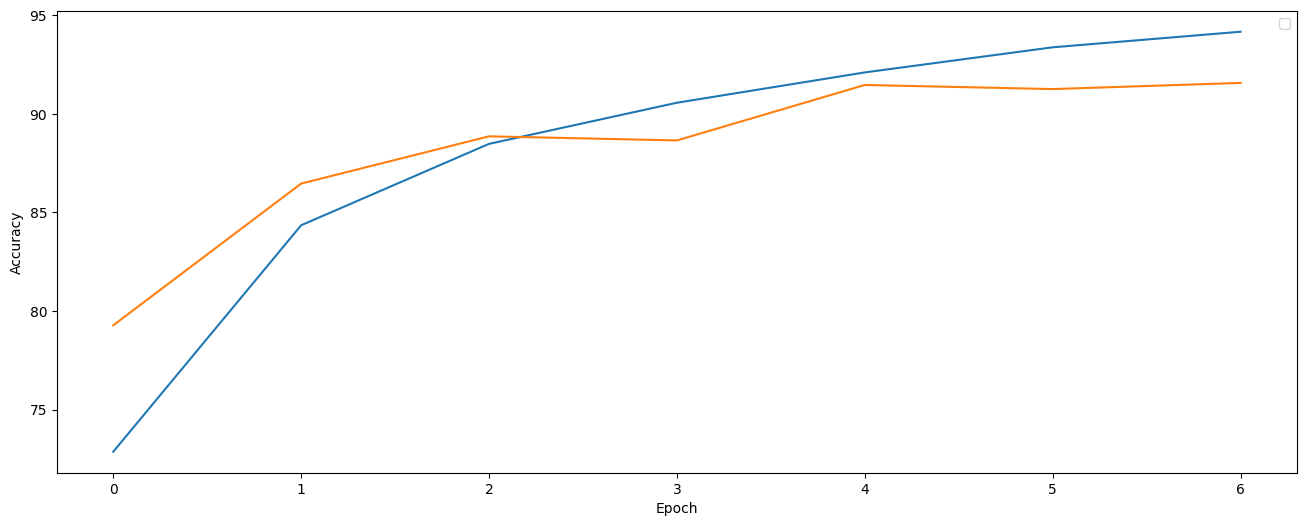

In [13]:
metrics = history.history

plt.figure(figsize=(16, 6))
plt.plot(history.epoch, 100 * np.array(metrics['accuracy']))
plt.plot(history.epoch, 100 * np.array(metrics['val_accuracy']))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [14]:
y_pred = model.predict(test_spec_ds)
y_pred = tf.argmax(y_pred, axis=1)

16/16 [==============================] - 2s 91ms/step


In [15]:
def convert_to_labels(label):
    return[labels[l] for l in label]

In [16]:
y_pred = convert_to_labels(y_pred)
y_true = convert_to_labels(tf.concat([label for _, label in test_spec_ds], axis=0))

for idx, (true_label, pred_label) in enumerate(zip(y_true, y_pred)):
    print(f"Data {idx}: Original Label -> {true_label},Prediction -> {pred_label}")

Data 0: Original Label -> follow,Prediction -> follow
Data 1: Original Label -> follow,Prediction -> follow
Data 2: Original Label -> visual,Prediction -> visual
Data 3: Original Label -> learn,Prediction -> learn
Data 4: Original Label -> follow,Prediction -> follow
Data 5: Original Label -> visual,Prediction -> visual
Data 6: Original Label -> learn,Prediction -> learn
Data 7: Original Label -> follow,Prediction -> follow
Data 8: Original Label -> follow,Prediction -> follow
Data 9: Original Label -> tree,Prediction -> tree
Data 10: Original Label -> follow,Prediction -> follow
Data 11: Original Label -> learn,Prediction -> learn
Data 12: Original Label -> tree,Prediction -> tree
Data 13: Original Label -> learn,Prediction -> follow
Data 14: Original Label -> visual,Prediction -> visual
Data 15: Original Label -> tree,Prediction -> tree
Data 16: Original Label -> follow,Prediction -> follow
Data 17: Original Label -> visual,Prediction -> visual
Data 18: Original Label -> learn,Predic